In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px
import folium 
import folium.plugins
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import warnings
warnings.filterwarnings("ignore")

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()

Loading BokehJS ...

In [3]:
# data loading and cleaning
dt1 = pd.read_csv('data/trip_data/trip_data_3.csv', nrows=100000)
dt1.drop(columns=' store_and_fwd_flag', inplace=True)
# dt2 = pd.read_csv('data/trip_data/trip_data_2.csv')

df1 = pd.read_csv('data/trip_fare/trip_fare_3.csv', nrows=100000)
# df2 = pd.read_csv('data/trip_fare/trip_fare_2.csv')
df = pd.merge(dt1, df1, how='left', on=['medallion', ' hack_license', ' vendor_id', ' pickup_datetime'])
for i in df.columns:
    df.rename(columns={i : i.strip(' ')}, inplace=True)
df['trip_time'] = df['trip_time_in_secs']/60
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    df[i] = df[i].replace(0,np.nan)
df.dropna(inplace=True)
# drop observations less than 0 and  greater than 99.9% percentile value.
df = df[(df["fare_amount"] > 0) & (
    df["fare_amount"] < df["fare_amount"].quantile(.999))]

df = df[(df["trip_distance"] > 0) & (
    df["trip_distance"] < df["trip_distance"].quantile(.9999))]

df = df[(df["trip_time_in_secs"] > 0) & (
    df["trip_time_in_secs"] < df["trip_time_in_secs"].quantile(.9999))]

for i in coord:
    df = df[(df[i] > df[i].quantile(.001)) &
            (df[i] < df[i].quantile(.999))]

In [8]:
def distance_points(df,x1_lat,x1_lon,x2_lat,x2_lon) :    
    R = 6373.0 #radius of the Earth in kilometers
    
    point1_lat = np.radians(df[x1_lat])
    point1_lon = np.radians(df[x1_lon])
    point2_lat = np.radians(df[x2_lat])
    point2_lon = np.radians(df[x2_lon])
    
    dist_lon = point2_lon - point1_lon
    dist_lat = point2_lat - point1_lat
    
    #Formula
    a = (np.sin(dist_lat/2))**2 + np.cos(point1_lat) * np.cos(point2_lat) * (np.sin(dist_lon/2))**2 
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
    d = R * c #(where R is the radius of the Earth)
    
    return d

In [9]:
jfk_data = df.copy()

#jfk coordinates
jfk_data["jfk_lat"] = 40.6413
jfk_data["jfk_lon"] = -73.7781

#distance_from jfk airport to pickup coordinates
jfk_data["dist_pickup_jfk"]  = distance_points(jfk_data,"pickup_latitude",
                                               "pickup_longitude",
                                              "jfk_lat","jfk_lon")

#distance_from jfk airport to dropoff coordinates
jfk_data["dist_dropoff_jfk"] = distance_points(jfk_data,"dropoff_latitude",
                                               "dropoff_longitude",
                                              "jfk_lat","jfk_lon")

#pick ups from 1km distance from jfk 
jfk_data_pickups  = jfk_data[(jfk_data["dist_pickup_jfk"] <  2)]
jfk_data_pickups["type"]  = "Pick up"
jfk_data_pickups = jfk_data_pickups.drop(columns = [ 'jfk_lat','jfk_lon'] ,
                                         axis = 1)

#dropoffs from 1km distance from jfk 
jfk_data_dropoffs = jfk_data[(jfk_data["dist_dropoff_jfk"] < 2)]
jfk_data_dropoffs["type"] = "Drop off"
jfk_data_dropoffs = jfk_data_dropoffs.drop(columns = [ 'jfk_lat', 'jfk_lon'] ,
                                           axis = 1)

#concat jfk pickups and dropoff
jfk = pd.concat([jfk_data_pickups,jfk_data_dropoffs],axis = 0)

#subset data which are not in jfk
not_jfk = df.drop(jfk.index,axis = 0)

#trips to jfk
jfk.head()

medallion                      hack_license  \
0    FE7B354FEB67B9C94BD34EA54469691C  2C78614ADC9C602EC70D65CCB4E63B14   
34   259EEA6AD00C7A69DBBB0DE7CB266E15  F136EDDBFC60D06C6988A068C500B0BA   
38   6A7DE4FA018649479E0971DDF7D0949A  30E78C70146FACBB4995134997E02253   
80   22A5E123C0E18D42743CF4C0F20092FD  799F8AFBD3901B949CEBFFB5C3574377   
121  C59C4F0D32DADA9B8ABF96CD5935F732  6B016F8CE1A7B6F7FF69D2B26ABCF001   

    vendor_id  rate_code      pickup_datetime     dropoff_datetime  \
0         CMT          1  2013-03-01 00:00:04  2013-03-01 00:19:03   
34        CMT          2  2013-03-01 00:00:53  2013-03-01 00:30:43   
38        CMT          2  2013-03-01 00:05:13  2013-03-01 00:27:13   
80        CMT          1  2013-03-01 00:00:20  2013-03-01 00:24:12   
121       CMT          2  2013-03-01 00:06:05  2013-03-01 00:43:20   

     passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  ...  \
0                  1               1138           14.3        -73.776703  ...   
34                 1               1790           18.1        -73.781631  ...   
38                 1               1320           17.2        -73.782127  ...   
80                 1               1432           20.1        -73.782921  ...   
121                1               2234           19.8        -73.782822  ...   

     fare_amount  surcharge  mta_tax tip_amount  tolls_amount  total_amount  \
0           39.5        0.5      0.5      10.10           0.0         50.60   
34          52.0        0.0      0.5      11.45           4.8         68.75   
38          52.0        0.0      0.5      11.46           4.8         68.76   
80          53.0        0.5      0.5      10.80           0.0         64.80   
121         52.0        0.0      0.5      11.46           4.8         68.76   

     trip_time  dist_pickup_jfk  dist_dropoff_jfk     type  
0    18.966667         0.445671         18.560622  Pick up  
34   29.833333         0.493461         22.806343  Pick up  
38   22.000000         0.498699         20.600348  Pick up  
80   23.866667         0.918274         19.487223  Pick up  
121  37.233333         0.523230         18.548196  Pick up  

[5 rows x 24 columns]

In [14]:
df[df["rate_code"] == 2][:100]

medallion                      hack_license  \
19    D886C7DC412D236CF1797D4B5BC90DDB  9B87622D5FD8A9F31C61FBA3C04DF8AD   
34    259EEA6AD00C7A69DBBB0DE7CB266E15  F136EDDBFC60D06C6988A068C500B0BA   
38    6A7DE4FA018649479E0971DDF7D0949A  30E78C70146FACBB4995134997E02253   
121   C59C4F0D32DADA9B8ABF96CD5935F732  6B016F8CE1A7B6F7FF69D2B26ABCF001   
208   3445DDD1C9D7E53CE70ABA3EA52A71B7  CA99469E60FC200FBAD0B711F059851B   
...                                ...                               ...   
3740  2B1A06E9228B7278227621EF1B879A1D  D812F96FB918ABF2C4B4EE37372055A0   
3810  C7C586831A57EACC5CE0D157D7E3617D  1FD12923F545A7F28AD05B7C334B5BB4   
3946  CA93F8576A51663C409C3DC2CA836DE8  E52D074F3CEDEB2F3E0A04BF5B7F8287   
3976  1A0B0E3A50ED7D37F0F07E5EDF95CB31  671D2913967E1A8AFBCA564E71DEBD83   
4123  4AFA303379D4D5F1771709C009DB926B  518BCE0D10BDD35A6AF18DB1B87318BC   

     vendor_id  rate_code      pickup_datetime     dropoff_datetime  \
19         CMT          2  2013-03-01 00:05:55  2013-03-01 00:39:25   
34         CMT          2  2013-03-01 00:00:53  2013-03-01 00:30:43   
38         CMT          2  2013-03-01 00:05:13  2013-03-01 00:27:13   
121        CMT          2  2013-03-01 00:06:05  2013-03-01 00:43:20   
208        VTS          2  2013-03-21 20:47:00  2013-03-21 21:21:00   
...        ...        ...                  ...                  ...   
3740       VTS          2  2013-03-28 19:10:00  2013-03-28 19:45:00   
3810       VTS          2  2013-03-25 06:43:00  2013-03-25 07:18:00   
3946       VTS          2  2013-03-25 14:30:00  2013-03-25 15:12:00   
3976       VTS          2  2013-03-25 07:10:00  2013-03-25 07:37:00   
4123       VTS          2  2013-03-25 18:28:00  2013-03-25 19:01:00   

      passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  \
19                  1               2009          20.00        -74.001114   
34                  1               1790          18.10        -73.781631   
38                  1               1320          17.20        -73.782127   
121                 1               2234          19.80        -73.782822   
208                 2               2040          18.90        -73.784584   
...               ...                ...            ...               ...   
3740                1               2100          17.06        -73.968544   
3810                1               2100          20.89        -73.975281   
3946                1               2520          16.90        -73.985497   
3976                1               1620          17.45        -73.781967   
4123                1               1980          16.41        -73.787331   

      ...  dropoff_longitude  dropoff_latitude  payment_type fare_amount  \
19    ...         -74.017822         40.851189           CRD        52.0   
34    ...         -73.997490         40.761204           CRD        52.0   
38    ...         -73.982224         40.743019           CRD        52.0   
121   ...         -73.972694         40.718952           CRD        52.0   
208   ...         -73.999840         40.724274           CRD        52.0   
...   ...                ...               ...           ...         ...   
3740  ...         -73.783241         40.648884           CSH        52.0   
3810  ...         -73.786125         40.643677           CRD        52.0   
3946  ...         -73.782249         40.648426           CSH        52.0   
3976  ...         -73.920967         40.864250           CSH        52.0   
4123  ...         -73.941185         40.813782           CRD        52.0   

      surcharge  mta_tax  tip_amount  tolls_amount  total_amount  trip_time  
19          0.0      0.5       13.80         16.50         82.80  33.483333  
34          0.0      0.5       11.45          4.80         68.75  29.833333  
38          0.0      0.5       11.46          4.80         68.76  22.000000  
121         0.0      0.5       11.46          4.80         68.76  37.233333  
208         0.0      0.5        0.0

In [19]:
trips_ln = df[df["rate_code"] == 2][900:950]

lat_center = 40.78
lon_center = -73.62

map_nyc = folium.Map(location=[lat_center,lon_center],
                    tiles="openstreetmap",max_zoom=15,zoom_start=10)


for i in range(0,len(trips_ln)) : 
    
    p1 = [trips_ln["pickup_latitude"].values[i],
          trips_ln["pickup_longitude"].values[i]]
    
    p2 = [trips_ln["dropoff_latitude"].values[i],
          trips_ln["dropoff_longitude"].values[i]]
    
    folium.Marker(location = p1,
                  icon=folium.Icon(color='green',
                                   icon = "home"),
                  popup = "Pick up = " + str(p1),
                 ).add_to(map_nyc)
    
    folium.Marker(location = p2,
                 icon=folium.Icon(color='blue',
                                  icon = "home"),
                  popup = "Drop off = " + str(p2),
                 ).add_to(map_nyc)
    
    folium.PolyLine(locations = [p1,p2] ,
                    color = "red",opacity = .9,
                   ).add_to(map_nyc)
    
   
map_nyc

In [26]:
trips_ln = df[df["trip_distance"] > 25 ]

lat_center = 40.78
lon_center = -73.62

map_nyc = folium.Map(location=[lat_center,lon_center],
                    tiles="openstreetmap",max_zoom=15,zoom_start=10)


for i in range(0,len(trips_ln)) : 
    
    p1 = [trips_ln["pickup_latitude"].values[i],
          trips_ln["pickup_longitude"].values[i]]
    
    p2 = [trips_ln["dropoff_latitude"].values[i],
          trips_ln["dropoff_longitude"].values[i]]
    
    folium.Marker(location = p1,
                  icon=folium.Icon(color='green',
                                   icon = "home"),
                  popup = "Pick up = " + str(p1),
                 ).add_to(map_nyc)
    
    folium.Marker(location = p2,
                 icon=folium.Icon(color='blue',
                                  icon = "home"),
                  popup = "Drop off = " + str(p2),
                 ).add_to(map_nyc)
    
    folium.PolyLine(locations = [p1,p2] ,
                    color = "red",opacity = .9,
                   ).add_to(map_nyc)
    
   
map_nyc

In [25]:
(df[df["trip_distance"] > 20])

medallion                      hack_license  \
13     46E1AE760E9E1FC1573B878C4FB9062A  C21B0744AFE2EB82768C26782238B35F   
80     22A5E123C0E18D42743CF4C0F20092FD  799F8AFBD3901B949CEBFFB5C3574377   
244    1855E1F1B1D92297C93CA62CAB39FEF6  48D44804028F10124B016D1AC9E63A0B   
345    8FD3E60B2A58B900EA73D7735D2E005C  5D7EB0CFCDAEF6939192726592CE4B2C   
462    6F6DB4FE34210F8B7B47C01B136FFFC1  D6FFC1679F5DC954CBA19E499772BDF7   
...                                 ...                               ...   
97241  790BCC5E600B53689C5920C40F9EECDD  73A3582E68C0BE8BAD8F19F61D65C36C   
97760  E4875E3542BE56CBBF7B5EABC0E7DD37  4AA2E92887BD14C86C9C7B2FE1709098   
97825  B4A29A1D0FEAB6CB015BEE6C6008F181  797F989F06D8914DBC73B98A7192D8FC   
98011  53112165A9F6D82B17C04DAF6A53E347  9EA84FBE846909C0C7E851645CAC73C5   
99347  75148F5ED6DECC2B4B4FAE2F61951EBB  B3D546C5E0330594843151E8C7447430   

      vendor_id  rate_code      pickup_datetime     dropoff_datetime  \
13          CMT          1  2013-03-01 00:05:14  2013-03-01 00:47:14   
80          CMT          1  2013-03-01 00:00:20  2013-03-01 00:24:12   
244         VTS          2  2013-03-24 21:30:00  2013-03-24 22:00:00   
345         VTS          2  2013-03-24 21:03:00  2013-03-24 21:29:00   
462         VTS          2  2013-03-24 23:47:00  2013-03-25 00:11:00   
...         ...        ...                  ...                  ...   
97241       VTS          2  2013-03-27 10:55:00  2013-03-27 11:32:00   
97760       VTS          2  2013-03-26 06:18:00  2013-03-26 07:07:00   
97825       VTS          1  2013-03-26 15:56:00  2013-03-26 16:58:00   
98011       VTS          1  2013-03-29 22:56:00  2013-03-29 23:32:00   
99347       VTS          2  2013-03-29 19:19:00  2013-03-29 19:59:00   

       passenger_count  trip_time_in_secs  trip_distance  pickup_longitude  \
13                   1               2519          22.00        -74.000793   
80                   1               1432          20.10        -73.782921   
244                  1               1800          20.86        -73.976189   
345                  4               1560          33.07        -73.789909   
462                  1               1440          21.74        -73.789192   
...                ...                ...            ...               ...   
97241                1               2220          20.49        -73.791069   
97760                5               2940          23.56        -73.780434   
97825                1               3720          20.18        -73.789291   
98011                2               2160          21.45        -73.973404   
99347                1               2400          20.01        -73.790321   

       ...  dropoff_longitude  dropoff_latitude  payment_type fare_amount  \
13     ...         -73.786713         40.843445           CRD        62.0   
80     ...         -74.002724         40.682049           CRD        53.0   
244    ...         -73.777832         40.644787           CRD        52.0   
345    ...         -73.972122         40.749641           CSH        52.0   
462    ...         -73.982269         40.723606           CSH        52.0   
...    ...                ...               ...           ...         ...   
97241  ...         -74.009781         40.720692           CRD        52.0   
97760  ...         -74.016586         40.715927           CRD        52.0   
97825  ...         -73.993126         40.688175           CSH        60.0   
98011  ...         -73.796875         40.713406           CSH        56.5   
99347  ...         -73.961914         40.762878           CSH        52.0   

       surcharge  mta_tax  tip_amount  tolls_amount  total_amount  trip_time  
13           0.5      0.5        20.0          0.00         83.00  41.983333  
80           0.5      0.5        10.8          0.00         64.80  23.866667  
244          0.0      0.5        10.4          5.33         68.23  30.000000  
345          0.0      0.5         0.0          5.33         57

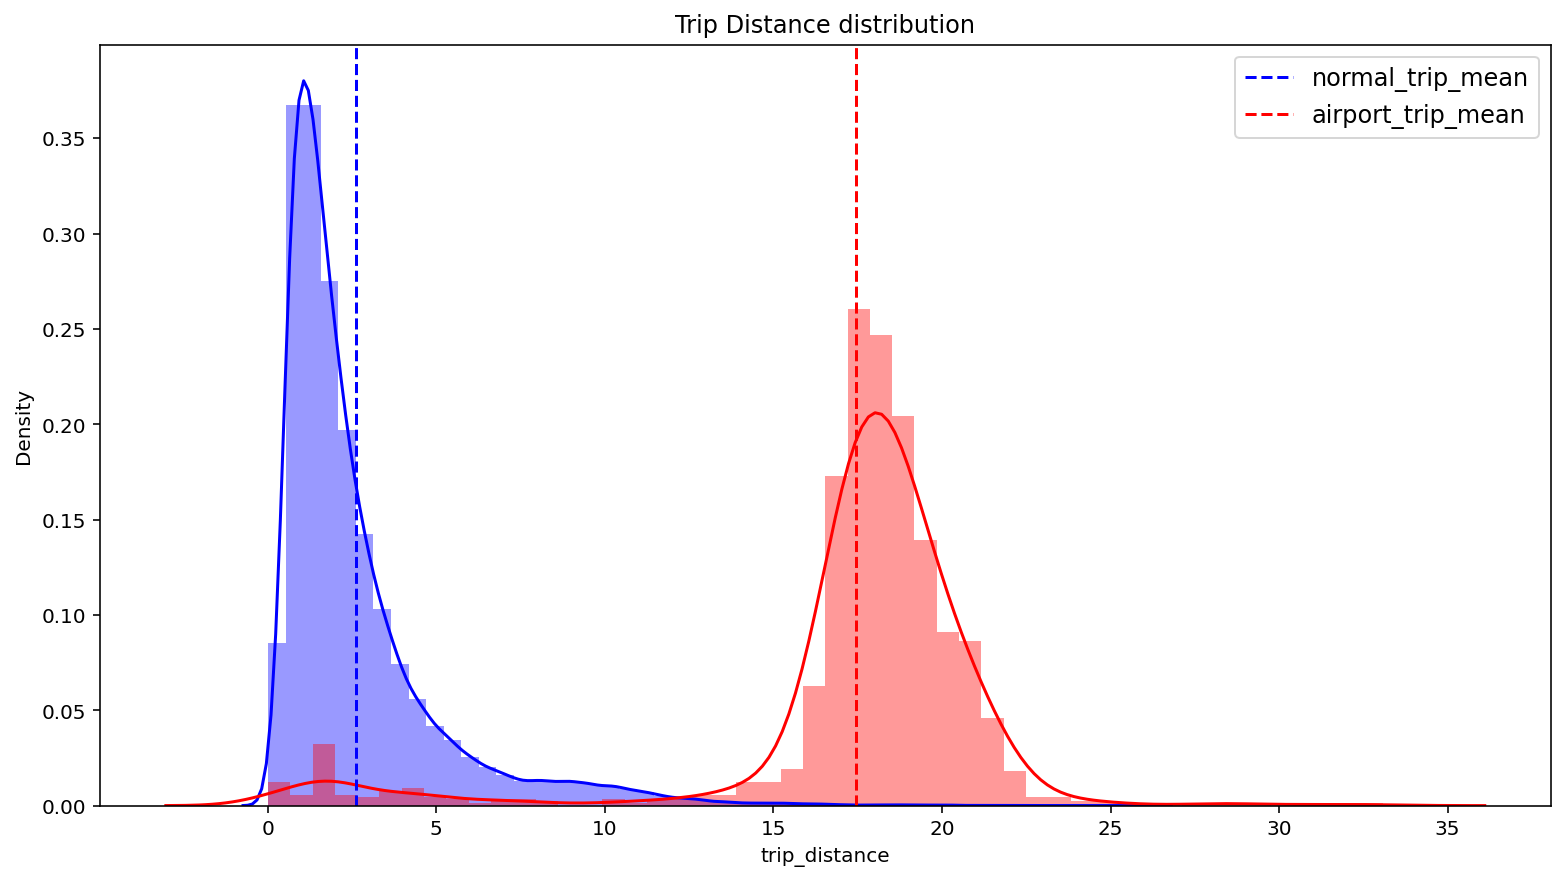

In [39]:
plt.figure(figsize = (13,7))
sns.distplot(df[df["rate_code"] == 1]['trip_distance'],color = "b")
sns.distplot(df[df["rate_code"] == 2]['trip_distance'],color = "r")
plt.axvline(df[df["rate_code"] == 1]['trip_distance'].mean(),
            color = "b",linestyle = "dashed",label = "normal_trip_mean")
plt.axvline(df[df["rate_code"] == 2]['trip_distance'].mean(),
            color = "r",linestyle = "dashed",label = "airport_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Trip Distance distribution")
plt.show()

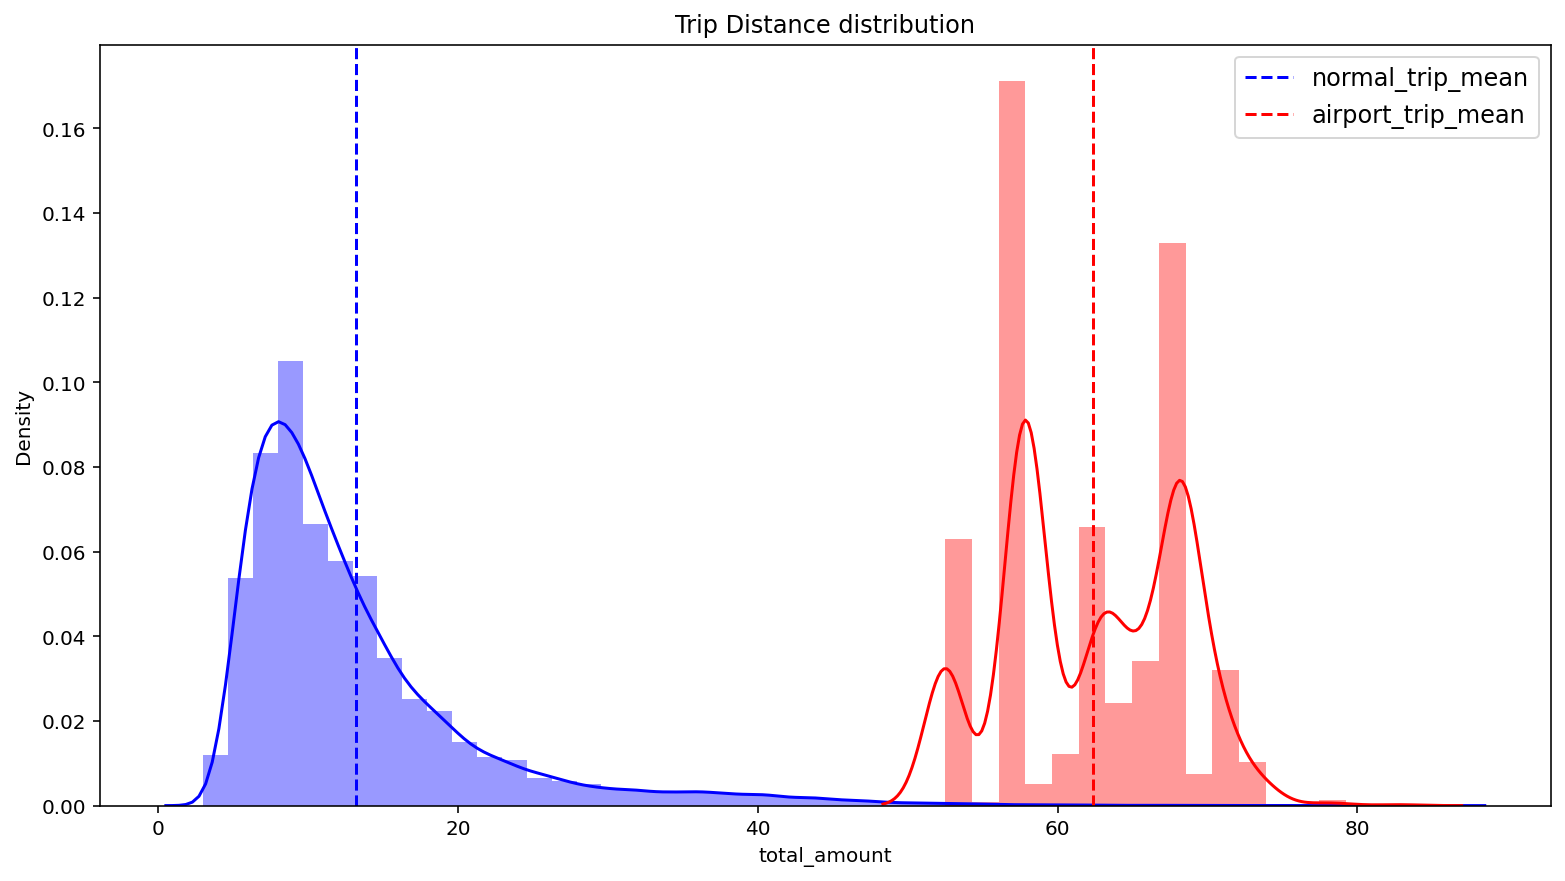

In [43]:
plt.figure(figsize = (13,7))
sns.distplot(df[df["rate_code"] == 1]['total_amount'],color = "b")
sns.distplot(df[df["rate_code"] == 2]['total_amount'],color = "r")
plt.axvline(df[df["rate_code"] == 1]['total_amount'].mean(),
            color = "b",linestyle = "dashed",label = "normal_trip_mean")
plt.axvline(df[df["rate_code"] == 2]['total_amount'].mean(),
            color = "r",linestyle = "dashed",label = "airport_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Trip Amount distribution")
plt.show()

In [47]:
px.histogram(df[['total_amount', 'tip_amount']], opacity=0.7, range_x=(1,100))

In [57]:
x0 = df[df['rate_code'] == 2]['tip_amount']
x1 = df[df['rate_code'] == 1]['tip_amount']


fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, marker_color='#330C73', name = 'Airport Trips'))
fig.add_trace(go.Histogram(x=x1, marker_color='#EB89B5', name = 'Normal Trips'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

NameError: name 'df' is not defined

In [ ]:
# Plot
plt.figure(figsize = (13,7))
sns.distplot(df[df["rate_code"] == 1]['trip_distance'],color = "b")
sns.distplot(df[df["rate_code"] == 2]['trip_distance'],color = "r")
plt.axvline(df[df["rate_code"] == 1]['trip_distance'].mean(),
            color = "b",linestyle = "dashed",label = "normal_trip_mean")
plt.axvline(df[df["rate_code"] == 2]['trip_distance'].mean(),
            color = "r",linestyle = "dashed",label = "airport_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Trip Distance distribution")
plt.show()

In [ ]:
# Plot
plt.figure(figsize = (13,7))
sns.distplot(df[df["rate_code"] == 1]['total_amount'],color = "b")
sns.distplot(df[df["rate_code"] == 2]['total_amount'],color = "r")
plt.axvline(df[df["rate_code"] == 1]['total_amount'].mean(),
            color = "b",linestyle = "dashed",label = "normal_trip_mean")
plt.axvline(df[df["rate_code"] == 2]['total_amount'].mean(),
            color = "r",linestyle = "dashed",label = "airport_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Trip Amount distribution")
plt.show()

In [ ]:
# Plot
x0 = df[df['rate_code'] == 2]['tip_amount']
x1 = df[df['rate_code'] == 1]['tip_amount']


fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, marker_color='#330C73', name = 'Airport Trips'))
fig.add_trace(go.Histogram(x=x1, marker_color='#EB89B5', name = 'Normal Trips'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()